In [9]:
# Imports
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import AGCRN,DCRNN,GConvGRU

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
import torch.nn.functional as F
from pathlib import Path
import pathlib
import numpy as np


In [10]:
import torch
import numpy as np
from typing import Sequence, Union
from torch_geometric.data import Data


Edge_Indices = Sequence[Union[np.ndarray, None]]
Edge_Weights = Sequence[Union[np.ndarray, None]]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]


class DynamicGraphTemporalSignal_custom(object):
    r"""A data iterator object to contain a dynamic graph with a
    changing edge set and weights . The feature set and node labels
    (target) are also dynamic. The iterator returns a single discrete temporal
    snapshot for a time period (e.g. day or week). This single snapshot is a
    Pytorch Geometric Data object. Between two temporal snapshots the edges,
    edge weights, target matrices and optionally passed attributes might change.

    Args:
        edge_indices (Sequence of Numpy arrays): Sequence of edge index tensors.
        edge_weights (Sequence of Numpy arrays): Sequence of edge weight tensors.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_indices: Edge_Indices,
        edge_weights: Edge_Weights,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_indices = edge_indices
        self.edge_weights = edge_weights
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        assert len(self.edge_indices) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        assert len(self.features) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self, time_index: int):
        if self.edge_indices[time_index] is None:
            return self.edge_indices[time_index]
        else:
            return torch.LongTensor(self.edge_indices[time_index])

    def _get_edge_weight(self, time_index: int):
        if self.edge_weights[time_index] is None:
            return self.edge_weights[time_index]
        else:
            return torch.FloatTensor(self.edge_weights[time_index])

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            return torch.LongTensor(self.targets[time_index])
            # if self.targets[time_index].dtype.kind == "i":
            #     return torch.LongTensor(self.targets[time_index])
            # elif self.targets[time_index].dtype.kind == "f":
            #     return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = DynamicGraphTemporalSignal(
                self.edge_indices[time_index],
                self.edge_weights[time_index],
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index(time_index)
            edge_weight = self._get_edge_weight(time_index)
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

In [11]:
traffic_dataset = torch.load('../SNA_create_graph/data/graph_data/2_hr_time_window_dynamic_graph/dataset_all_route_dynamic_graph.pt')


In [12]:
len(traffic_dataset)

7147

In [13]:
# Removing graphs that just have zero bin in the graph to reduce sparsity
cleaned_traffic_dataset = []

for dataset in traffic_dataset:
    y_list = np.array(dataset.y)
    non_zero = np.count_nonzero(y_list)
    if(non_zero == 0):
        continue
    else:
        cleaned_traffic_dataset.append(dataset)

traffic_dataset = cleaned_traffic_dataset

In [14]:
len(cleaned_traffic_dataset)

6936

In [15]:
class myNewOwnLoader(object):
    """A dataset of county level chicken pox cases in Hungary between 2004
    and 2014. We made it public during the development of PyTorch Geometric
    Temporal. The underlying graph is static - vertices are counties and
    edges are neighbourhoods. Vertex features are lagged weekly counts of the
    chickenpox cases (we included 4 lags). The target is the weekly number of
    cases for the upcoming week (signed integers). Our dataset consist of more
    than 500 snapshots (weeks).
    """

    def __init__(self, dataset):
        # self._read_web_data()
        self._get_dataset(dataset)

    def _get_dataset(self,dataset):
        self._dataset = dataset

    def _get_edges(self):
        # self._edges = np.array(self._dataset["edges"]).T
        # ei = []
        # for data in self._dataset:
        #     ei.append(data.edge_index)
        e = []
        for data in self._dataset:
            e.append(data.edge_index)

        self._edges = e


    def _get_edge_weights(self):
        # self._edge_weights = np.ones(self._edges.shape[1])
        # ew = []
        # for data in self._dataset:
        #     ew.append(data.edge_attr)
        ew = []
        for data in self._dataset:
            ew.append(data.edge_attr[:, 0])

        self._edge_weights = ew

        # self._edge_weights = np.array(self._dataset[0].edge_attr)
        # self._edge_weights = self._dataset.edge_attr

    def _get_targets(self):

        y_class = []
        for data in self._dataset:
            y_class.append(data.y)

        self.targets = y_class
        # self.targets = self._dataset.y

    def _get_features(self):
        f = []
        for data in self._dataset:
            f.append(data.x)

        self.features = f
        # self.features = self._dataset.x

    def get_dataset(self, lags: int = 8) -> DynamicGraphTemporalSignal_custom:
        """Returning the Chickenpox Hungary data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Chickenpox Hungary dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets()
        self._get_features()
        # self._get_targets_and_features()
        # self.

        dataset = DynamicGraphTemporalSignal_custom(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_dataset, test_dataset =  train_test_split(traffic_dataset, test_size =.20, shuffle  = True,random_state=42)
train_dataset, validation_dataset =  train_test_split(train_dataset, test_size =.12, shuffle  = True,random_state=42)


In [18]:
newloader_train = myNewOwnLoader(train_dataset)
train_dataset = newloader_train.get_dataset(lags=8)

newloader_val = myNewOwnLoader(validation_dataset)
validation_dataset = newloader_val.get_dataset(lags=8)

newloader_test = myNewOwnLoader(test_dataset)
test_dataset = newloader_test.get_dataset(lags=8)

In [19]:
train_dataset[0], validation_dataset[0], test_dataset[0]

(Data(x=[257, 10], edge_index=[2, 254], edge_attr=[254], y=[257]),
 Data(x=[325, 10], edge_index=[2, 326], edge_attr=[326], y=[325]),
 Data(x=[224, 10], edge_index=[2, 222], edge_attr=[222], y=[224]))

In [20]:
y_train = []

for dataset in train_dataset:
    y_train += list(np.array(dataset.y))
    # y_train.append(np.array(dataset.y))



In [21]:
y_train = np.array(y_train)

class_counts = np.bincount(y_train)
num_classes = 4
total_samples = len(y_train)

class_weights = []
for count in class_counts:
    weight = 1 / (count / total_samples)
    class_weights.append(weight)

In [22]:
class_counts, class_weights

# array([158929,  86989,  21581,   8111])

(array([506018, 320442,  48859,  15477]),
 [1.7604037801026842,
  2.779897766210422,
  18.23197363842895,
  57.556115526264776])

In [23]:

def train_one_epoch(train_loader, e):
    model.train()

    # Initial parameters
    cost = 0
    h = None
    count = 0 
    correct = 0
    for time, snapshot in enumerate(train_loader):
        # x = snapshot.x.view(1, no_of_nodes, no_of_node_features)
        # y_hat, h = model(x, e, h)
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)


        #### UNCOMMENT below for cross entropy loss ###
        # Assuming snapshot.y is of shape [20] and has values in the range [0, 4]
        # snapshot_y_one_hot = F.one_hot(snapshot.y, num_classes=num_classes).unsqueeze(0)
        # cost = cost + criterion(y_hat, snapshot_y_one_hot.float())
        # cost = cost + criterion(snapshot_y_one_hot.float(),y_hat)
        ############

        # Getting the focal loss
        cost = cost + focal_loss(y_hat.squeeze(), snapshot.y.long())
        pred = y_hat.argmax(dim=1)  # Use the class with highest probability.
        yp = np.array(pred).flatten()
        yt = np.array(snapshot.y).flatten()
        correct += int((yp == yt).sum()) 
        count += len(yt)
    cost = cost / (time+1) #Getting the mean loss
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    accuracy = correct / count

    return accuracy, cost

def validate_one_epoch(validation_loader, e):
    model.eval()

    # Initial parameters
    cost = 0
    h = None
    count = 0 
    correct = 0
    for time, snapshot in enumerate(validation_loader):
        # x = snapshot.x.view(1, no_of_nodes, no_of_node_features)
        # y_hat, h = model(x, e, h)
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)

        #### UNCOMMENT below for cross entropy loss ###
        # Assuming snapshot.y is of shape [20] and has values in the range [0, 4]
        # snapshot_y_one_hot = F.one_hot(snapshot.y, num_classes=num_classes).unsqueeze(0)
        # cost = cost + criterion(y_hat, snapshot_y_one_hot.float())
        # cost = cost + criterion(snapshot_y_one_hot.float(),y_hat)
        ############

        # Getting the focal loss
        cost = cost + focal_loss(y_hat.squeeze(), snapshot.y.long())
        pred = y_hat.argmax(dim=1)  # Use the class with highest probability.
        yp = np.array(pred).flatten()
        yt = np.array(snapshot.y).flatten()
        correct += int((yp == yt).sum()) 
        count += len(yt)
    cost = cost / (time+1) #Getting the mean loss
    
    accuracy = correct / count
    return accuracy, cost


In [24]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss
    
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):

        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [25]:
# Data(x=[45, 10], edge_index=[2, 94], edge_attr=[94, 7], y=[45])

In [26]:
# no_of_nodes = 45
no_of_node_features = 10
num_classes = 4
lr = 0.01 

EPOCHS = 500
patience = 70
early_stopper = EarlyStopper(patience=patience, min_delta=0)


from torch_geometric_temporal.nn.recurrent import AGCRN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, num_classes):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(in_channels = node_features,
                              out_channels = 16,K=1)
        # Future work add some MLP layers, increase out channels - to 64.in the future
        self.linear = torch.nn.Linear(16, num_classes)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h
        
model = RecurrentGCN(node_features = no_of_node_features, num_classes=num_classes)
# model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [27]:
class_weights = torch.FloatTensor(class_weights)
focal_loss = torch.hub.load(
	'adeelh/pytorch-multi-class-focal-loss',
	model='FocalLoss',
	alpha=class_weights,
	gamma=2,
	reduction='mean',
	force_reload=False
)

Using cache found in /home/sgupta/.cache/torch/hub/adeelh_pytorch-multi-class-focal-loss_master


In [28]:

model_checkpoint_path = './model_checkpoint/GConvGRU/'
pathlib.Path(model_checkpoint_path).mkdir(parents=True, exist_ok=True) 

e = None
# e = torch.empty(no_of_nodes, 4)
# torch.nn.init.xavier_uniform_(e)

history = {
    'epoch':[],
    'train_acc':[],
    'validation_acc':[],
    'train_loss':[],
    'validation_loss':[]
}

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train_one_epoch(train_dataset, e)
    validation_acc, validation_loss = validate_one_epoch(validation_dataset, e)
    # print(validation_loss)
    PATH  = f'{model_checkpoint_path}/model_GConvGRU_2_hr_{epoch}.pt'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'validation_loss': validation_loss,
            }, PATH)
    
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {validation_acc:.4f}, Val Loss: {validation_loss:.4f}')

    history['epoch'].append(epoch+1)
    history['train_acc'].append(train_acc)
    history['validation_acc'].append(validation_acc)
    history['train_loss'].append(float(train_loss.data))
    history['validation_loss'].append(float(validation_loss.data))
    
    if early_stopper.early_stop(validation_loss):     
        print(f"Stopping early! {validation_loss}, {epoch}")      
        break


  0%|          | 1/200 [00:19<1:05:38, 19.79s/it]

Epoch: 000, Train Acc: 0.0845, Train Loss: 2.9638, Val Acc: 0.3726, Val Loss: 3.1547


  0%|          | 1/200 [00:29<1:38:06, 29.58s/it]


KeyboardInterrupt: 

In [26]:
# Experiment_results_saving path

experiment_results_path = './exp_results/'
pathlib.Path(experiment_results_path).mkdir(parents=True, exist_ok=True)

In [44]:
best_epoch = epoch - patience
best_epoch

160

In [53]:
# best_epoch = epoch - patience

# tmodel = torch.load(f'/home/sgupta/WORK/Stoplevel_day_ahead_prediction/GNN_new_graph_stoplevel/model_checkpoint/GConvGRU/model_GConvGRU_{best_epoch}.pt')

model2 = model
# model2.load_state_dict(tmodel['model_state_dict'])

In [59]:
# model2.load_state_dict(tmodel['model_state_dict'])

<All keys matched successfully>

In [27]:
lr = lr
EPOCHS = EPOCHS
patience = patience
loss = 'focal_loss'
node_features_used = no_of_node_features
edge_features_used = 0

In [34]:
curr_experiment_path = f'{experiment_results_path}/GConvGRU_2_hr_time_window/lr_{lr}_epochs_{EPOCHS}_patience_{patience}_loss_{loss}_no_node_f_{node_features_used}_no_edge_f_{edge_features_used}'
pathlib.Path(curr_experiment_path).mkdir(parents=True, exist_ok=True) 

In [60]:

def test(loader):
    model.eval()

    correct=0
    count=0
    y_true = []
    y_pred = []

    h = None
    for time, snapshot in enumerate(loader):
        # x = snapshot.x.view(1, no_of_nodes,no_of_node_features)
        y_hat = model2(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        
        # Assuming snapshot.y is of shape [20] and has values in the range [0, 4]
        # snapshot_y_one_hot = F.one_hot(snapshot.y, num_classes=num_classes).unsqueeze(0)

        pred = y_hat.argmax(dim=1)  # Use the class with highest probability.
        y_true.append(snapshot.y)
        y_pred.append(pred)

        yp = np.array(pred).flatten()
        yt = np.array(snapshot.y).flatten()
        correct += int((yp == yt).sum()) 
        count += len(yt)

    return (correct/count), y_true, y_pred


test_acc,  y_true, y_pred = test(test_dataset)

In [61]:
import pandas as pd

yt = np.concatenate([tensor.flatten() for tensor in y_true])
yp = np.concatenate([tensor.flatten() for tensor in y_pred])

temp = pd.DataFrame(columns=['ytrue','ypred'])
temp.ytrue = yt
temp.ypred = yp

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def get_CM(y_true,y_pred,title,comment,path):
    test_acc = (y_pred == y_true).sum()/len(y_true)

    print(f"Accuracy {comment}:",test_acc)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    _ = disp.plot(ax=ax)
    # Add a title to the plot
    ax.set_title(title + " - Real Count")
    # plt.savefig(f'{path}/CM_real_55_{comment}.jpg')
    plt.show()

    # Getting the percentage CM
    cm = ((cm * 100) / (cm.sum(axis=1)[:, np.newaxis]))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    _ = disp.plot(ax=ax)
    # Add a title to the plot
    ax.set_title(title + " - Percentages")
    # plt.savefig(f'{path}/CM_percentage_55{comment}.jpg')
    plt.show()

    return test_acc

Accuracy with 4th bin: 0.4176615501231761


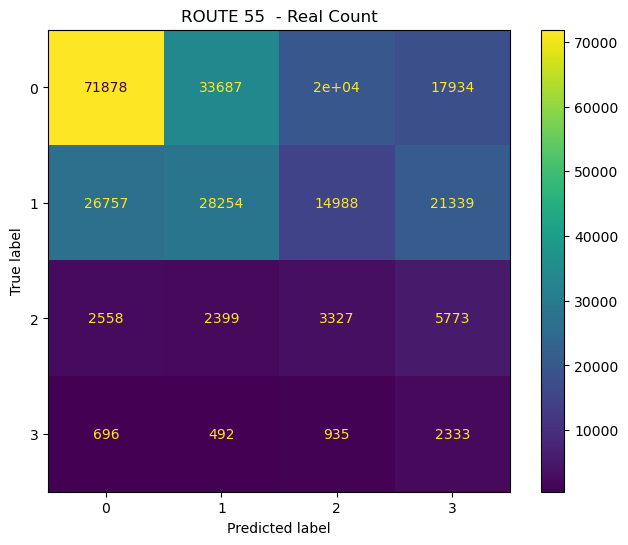

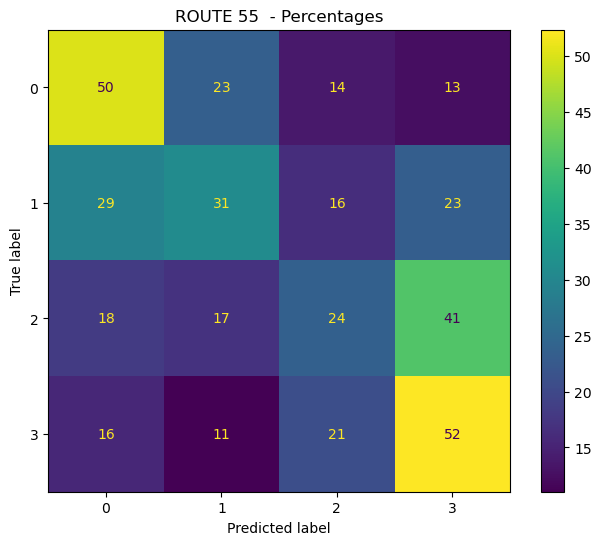

In [63]:
test_acc_w_4th = get_CM(temp.ytrue,temp.ypred,'ROUTE 55 ','with 4th bin',curr_experiment_path)
history['test_acc_with_4th_bin'] = test_acc_w_4th


In [40]:
history_df = pd.DataFrame(history)
history_df.to_csv(f'./{curr_experiment_path}/history_w_results.csv')

In [ ]:
def accuracy_metric(y_true,y_pred):
        a = []
        
        for i in range(len(y_true)):
            yt = y_true[i]
            yp = y_pred[i]

            temp = 1 - (np.abs(yt-yp)/num_classes)
            a.append(temp)
        # print(a)
        accuracy = sum(a)/len(y_true)

        return accuracy

custom_accuracy = accuracy_metric(temp.ytrue,temp.ypred)
print('Custom Accuracy Metric:',custom_accuracy)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, support = precision_recall_fscore_support(temp.ytrue,temp.ypred, average='weighted')

In [ ]:
# Open a file in write mode ('w' or 'a' for append)
with open('./results/dn_de_2_hr/dynamic_node_dynamic_edge_2_hr_output.txt', 'w') as file:
    # Write data to the file
    file.write(f"The precision, recall and f1-score are: {precision}, {recall} and {f1_score}\n")
    file.write(f'Custom Accuracy Metric: {custom_accuracy}')

In [ ]:
temp.to_csv('./results/dn_de_2_hr/dynamic_node_dynamic_edge_2_hr_preds.csv')